# Settings

In [1]:
EXP_NO = 7
SEED = 1
N_SPLITS = 5
TARGET = 'sorting_date'
GROUP = 'art_series_id'
REGRESSION = True

In [2]:
assert((TARGET, REGRESSION) in (('target', True), ('target', False), ('sorting_date', True)))

# Library

In [3]:
from collections import defaultdict
from functools import partial
import gc
import glob
import json
from logging import getLogger, StreamHandler, FileHandler, DEBUG, Formatter
import pickle
import os
import sys
import time

import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.feature import hog
from sklearn.svm import SVR
from sklearn.metrics import confusion_matrix, mean_squared_error, cohen_kappa_score

SCRIPTS_DIR = os.path.join('..', 'scripts')
assert(os.path.isdir(SCRIPTS_DIR))
if SCRIPTS_DIR not in sys.path: sys.path.append(SCRIPTS_DIR)

from cross_validation import load_cv_object_ids
from dataset import load_csvfiles, load_photofile
from folder import experiment_dir_of
from target import soring_date2target

In [4]:
pd.options.display.float_format = '{:.5f}'.format

# Prepare directory

In [5]:
output_dir = experiment_dir_of(EXP_NO)

In [6]:
output_dir

'..\\scripts\\..\\experiments\\exp007'

# Prepare logger

In [7]:
logger = getLogger(__name__)

In [8]:
'''Refference
https://docs.python.org/ja/3/howto/logging-cookbook.html
'''
logger.setLevel(DEBUG)
# create file handler which logs even debug messages
fh = FileHandler(os.path.join(output_dir, 'log.log'))
fh.setLevel(DEBUG)
# create console handler with a higher log level
ch = StreamHandler()
ch.setLevel(DEBUG)
# create formatter and add it to the handlers
formatter = Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)
len(logger.handlers)

2

In [9]:
logger.info('Experiment no: {}'.format(EXP_NO))
logger.info('CV: StratifiedGroupKFold')
logger.info('SEED: {}'.format(SEED))
logger.info('REGRESSION: {}'.format(REGRESSION))
logger.info('TARGET: {}'.format(TARGET))

2021-07-17 18:24:45,580 - __main__ - INFO - Experiment no: 7
2021-07-17 18:24:45,583 - __main__ - INFO - CV: StratifiedGroupKFold
2021-07-17 18:24:45,585 - __main__ - INFO - SEED: 1
2021-07-17 18:24:45,586 - __main__ - INFO - REGRESSION: True
2021-07-17 18:24:45,587 - __main__ - INFO - TARGET: sorting_date


# Load csv files

In [10]:
SINCE = time.time()

In [11]:
logger.debug('Start loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))
train, test, materials, techniques, sample_submission = load_csvfiles()
logger.debug('Complete loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-17 18:24:45,629 - __main__ - DEBUG - Start loading csv files (0.020 seconds passed)
2021-07-17 18:24:45,661 - __main__ - DEBUG - Complete loading csv files (0.052 seconds passed)


In [12]:
train

,object_id,sorting_date,art_series_id,target
0,002bff09b09998d0be65,1631,509357f67692a6a45626,1
1,00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3
2,003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3
3,004890880e8e7431147b,1743,582ac2d7f0cef195b605,2
4,00718c32602425f504c1,1885,64c907f0c08dce4fb8e8,3
...,...,...,...,...
3932,ffa3259fff8e6f3818a1,1850,b187c294b0550acf049a,3
3933,ffd4d361756587883e48,1670,ad49a044770a48f860a6,1
3934,ffd794b7b311b7b7fd92,1789,f030a01b480b18a27be2,2
3935,ffe49bba69d06446de7e,1805,f5287bc84a05aada1d17,3


In [13]:
test

,object_id
0,0009e50b94be36ccad39
1,000bd5e82eb22f199f44
2,0015f44de1854f617516
3,00388a678879ba1efa27
4,005e1e7c6496902d23f3
...,...
5914,ffbe65ad399b632dcbd0
5915,ffd7b2d646c0320c311a
5916,ffdb93ede17d4501e530
5917,ffe111402004b0ed46b4


# Feature engineering

## Extract hog features

In [14]:
%%time
path_train_hog_feature = os.path.join('exp006', 'train_hog_features.pkl')
if os.path.isfile(path_train_hog_feature):
    with open(path_train_hog_feature, 'rb') as f:
        train_hog_features = pickle.load(f)
else:
    train_hog_features = {object_id: hog(load_photofile(object_id)) for object_id in train['object_id']}
    with open(path_train_hog_feature, 'wb') as f:
        pickle.dump(train_hog_features, f)

Wall time: 1.5 s


In [15]:
%%time
path_test_hog_feature = os.path.join('exp006', 'test_hog_features.pkl') 
if os.path.isfile(path_test_hog_feature):
    with open(path_test_hog_feature, 'rb') as f:
        X_test = pickle.load(f)
else:
    X_test = np.array([hog(load_photofile(object_id)) for object_id in test['object_id']])
    with open(path_test_hog_feature, 'wb') as f:
        pickle.dump(X_test, f)

Wall time: 2.98 s


# Cross validation

In [16]:
train.set_index('object_id', inplace=True)

In [17]:
fold_object_ids = load_cv_object_ids()
for i, (train_object_ids, valid_object_ids) in enumerate(zip(fold_object_ids[0], fold_object_ids[1])):
    assert(set(train_object_ids) & set(valid_object_ids) == set())
    num_fold = i + 1
    logger.debug('Start fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))
    # Separate dataset into training/validation fold
    X_train = np.array([train_hog_features[object_id] for object_id in train_object_ids])
    y_train = train.loc[train_object_ids, TARGET].values
    X_valid = np.array([train_hog_features[object_id] for object_id in valid_object_ids])
    y_valid = train.loc[valid_object_ids, TARGET].values
    
    # Training
    logger.debug('Start training model ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## train estimator
    estimator = SVR(C=10.0)
    estimator.fit(X_train, y_train)
    logger.debug('Complete training ({:.3f} seconds passed)'.format(time.time() - SINCE))
    
    # Save model and prediction
    ## Prediction
    if REGRESSION:
        pred_train = pd.DataFrame(data=estimator.predict(X_train), columns=['pred'])
        pred_valid = pd.DataFrame(data=estimator.predict(X_valid), columns=['pred'])
        pred_test = pd.DataFrame(data=estimator.predict(X_test), columns=['pred'])
    else:
        try:
            pred_train = pd.DataFrame(data=estimator.predict_proba(X_train),
                                      columns=estimator.classes_)
            pred_valid = pd.DataFrame(data=estimator.predict_proba(X_valid),
                                      columns=estimator.classes_)
            pred_test = pd.DataFrame(data=estimator.predict_proba(X_test),
                                     columns=estimator.classes_)
        except AttributeError:
            pred_train = pd.DataFrame(data=estimator.decision_function(X_train),
                                      columns=estimator.classes_)
            pred_valid = pd.DataFrame(data=estimator.decision_function(X_valid),
                                      columns=estimator.classes_)
            pred_test = pd.DataFrame(data=estimator.decision_function(X_test),
                                     columns=estimator.classes_)
    ## Training set
    pred_train['object_id'] = train_object_ids
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train.to_csv(filepath_fold_train, index=False)
    logger.debug('Save training fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_train, time.time() - SINCE))
    ## Validation set
    pred_valid['object_id'] = valid_object_ids
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid.to_csv(filepath_fold_valid, index=False)
    logger.debug('Save validation fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_valid, time.time() - SINCE))
    ## Test set
    pred_test['object_id'] = test['object_id'].values
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test.to_csv(filepath_fold_test, index=False)
    logger.debug('Save test result {} ({:.3f} seconds passed)' \
                 .format(filepath_fold_test, time.time() - SINCE))
    ## Model
    filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.pkl')
    with open(filepath_fold_model, 'wb') as f:
        pickle.dump(estimator, f)
    logger.debug('Save model {} ({:.3f} seconds passed)'.format(filepath_fold_model, time.time() - SINCE))
    
    # Save memory
    del (estimator, X_train, X_valid, y_train, y_valid, pred_train, pred_valid, pred_test)
    gc.collect()

    logger.debug('Complete fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

2021-07-17 18:24:50,243 - __main__ - DEBUG - Start fold 1 (4.633 seconds passed)
2021-07-17 18:24:50,975 - __main__ - DEBUG - Start training model (5.365 seconds passed)
2021-07-17 18:28:08,342 - __main__ - DEBUG - Complete training (202.733 seconds passed)
2021-07-17 18:53:38,044 - __main__ - DEBUG - Save training fold to ..\scripts\..\experiments\exp007\cv_fold1_training.csv (1732.435 seconds passed)
2021-07-17 18:53:38,065 - __main__ - DEBUG - Save validation fold to ..\scripts\..\experiments\exp007\cv_fold1_validation.csv (1732.456 seconds passed)
2021-07-17 18:53:38,099 - __main__ - DEBUG - Save test result ..\scripts\..\experiments\exp007\cv_fold1_test.csv (1732.490 seconds passed)
2021-07-17 18:53:40,015 - __main__ - DEBUG - Save model ..\scripts\..\experiments\exp007\cv_fold1_model.pkl (1734.406 seconds passed)
2021-07-17 18:53:40,508 - __main__ - DEBUG - Complete fold 1 (1734.899 seconds passed)
2021-07-17 18:53:40,509 - __main__ - DEBUG - Start fold 2 (1734.900 seconds passed

# Evaluation

In [18]:
rmse = partial(mean_squared_error, squared=False)

In [19]:
# qwk = partial(cohen_kappa_score, labels=np.sort(train['target'].unique()), weights='quadratic')

In [20]:
@np.vectorize
def predict(proba_0: float, proba_1: float, proba_2: float, proba_3: float) -> int:
    return np.argmax((proba_0, proba_1, proba_2, proba_3))

In [21]:
metrics = defaultdict(list)

## Training set

In [31]:
pred_train_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (training set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train_df = pd.read_csv(filepath_fold_train)
    pred_train_df['actual'] = train.loc[pred_train_df['object_id'], TARGET].values
    if REGRESSION:
        if TARGET == 'target':
            pred_train_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_train_df['pred'] = np.vectorize(soring_date2target)(pred_train_df['pred'])
            pred_train_df['actual'] = np.vectorize(soring_date2target)(pred_train_df['actual'])
    else:
        pred_train_df['pred'] = predict(pred_train_df['0'], pred_train_df['1'],
                                        pred_train_df['2'], pred_train_df['3'])
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_train_df['actual'], pred_train_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_train_df['actual'], pred_train_df['pred'])
#     score = qwk(pred_train_df['actual'], pred_train_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['train_losses'].append(loss)
#     metrics['train_scores'].append(score)
    pred_train_dfs.append(pred_train_df)

metrics['train_losses_avg'] = np.mean(metrics['train_losses'])
metrics['train_losses_std'] = np.std(metrics['train_losses'])
# metrics['train_scores_avg'] = np.mean(metrics['train_scores'])
# metrics['train_scores_std'] = np.std(metrics['train_scores'])

2021-07-17 22:56:31,484 - __main__ - DEBUG - Evaluate cv result (training set) Fold 1
2021-07-17 22:56:31,517 - __main__ - DEBUG - Loss: 0.927293163710899
2021-07-17 22:56:31,518 - __main__ - DEBUG - Evaluate cv result (training set) Fold 2
2021-07-17 22:56:31,539 - __main__ - DEBUG - Loss: 0.9233516654054185
2021-07-17 22:56:31,539 - __main__ - DEBUG - Evaluate cv result (training set) Fold 3
2021-07-17 22:56:31,554 - __main__ - DEBUG - Loss: 0.9122615650198098
2021-07-17 22:56:31,554 - __main__ - DEBUG - Evaluate cv result (training set) Fold 4
2021-07-17 22:56:31,583 - __main__ - DEBUG - Loss: 0.9357534492410368
2021-07-17 22:56:31,583 - __main__ - DEBUG - Evaluate cv result (training set) Fold 5
2021-07-17 22:56:31,608 - __main__ - DEBUG - Loss: 0.9278275920992741


[[   0   60  309    0]
 [   0   37  671    6]
 [   0    2 1181   23]
 [   0    1  680  170]]
[[   0   76  307    1]
 [   0   56  653    6]
 [   0    4 1188   23]
 [   0    2  670  175]]
[[   0   89  287    2]
 [   0   75  621   11]
 [   0    6 1156   39]
 [   0    3  642  216]]
[[   0   50  331    1]
 [   0   31  676    6]
 [   0    1 1221   15]
 [   0    1  657  162]]
[[   0   80  305    2]
 [   0   62  668    5]
 [   0    3 1164   18]
 [   0    2  675  164]]


In [65]:
pred_train = pd.concat(pred_train_dfs).groupby('object_id').sum()
pred_train = pred_train / N_SPLITS
if not REGRESSION:
    pred_train['pred'] = predict(pred_train['0'], pred_train['1'], pred_train['2'], pred_train['3'])
pred_train['actual'] = train.loc[pred_train.index, TARGET].values
if REGRESSION and TARGET == 'sorting_date':
    pred_train['actual'] = np.vectorize(soring_date2target)(pred_train['actual'])
# for c in ('pred', 'actual'):
#     pred_train[c] = pred_train[c].astype('int')
pred_train

,pred,actual
object_id,,
002bff09b09998d0be65,1.60000,1
00309fb1ef05416f9c1f,1.60000,3
003a1562e97f79ba96dc,2.40000,3
004890880e8e7431147b,1.60000,2
00718c32602425f504c1,1.80000,3
...,...,...
ffa3259fff8e6f3818a1,1.60000,3
ffd4d361756587883e48,1.60000,1
ffd794b7b311b7b7fd92,1.60000,2


In [49]:
if not (REGRESSION and TARGET == 'target'):
    print(confusion_matrix(pred_train['actual'], pred_train['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_train['actual'], pred_train['pred'])
# score = qwk(pred_train['actual'], pred_train['pred'])
metrics['train_loss'] = loss
# metrics['train_score'] = score
logger.info('Training loss: {}'.format(loss))
# logger.info('Training score: {}'.format(score))

2021-07-17 23:03:14,315 - __main__ - INFO - Training loss: 1.1807661870233146


[[  64  410    1    0]
 [  35  853    8    0]
 [   1 1481   29    0]
 [   1  828  226    0]]


In [50]:
pred_train.to_csv(os.path.join(output_dir, 'prediction_train.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_train.csv')))

2021-07-17 23:03:18,394 - __main__ - DEBUG - Write cv result to ..\scripts\..\experiments\exp007\prediction_train.csv


## Validation set

In [51]:
pred_valid_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (validation set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid_df = pd.read_csv(filepath_fold_valid)
    pred_valid_df['actual'] = train.loc[pred_valid_df['object_id'], TARGET].values
    if REGRESSION:
        if TARGET == 'target':
            pred_valid_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_valid_df['pred'] = np.vectorize(soring_date2target)(pred_valid_df['pred'])
            pred_valid_df['actual'] = np.vectorize(soring_date2target)(pred_valid_df['actual'])
    else:
        pred_valid_df['pred'] = predict(pred_valid_df['0'], pred_valid_df['1'],
                                        pred_valid_df['2'], pred_valid_df['3'])        
    
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_valid_df['actual'], pred_valid_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_valid_df['actual'], pred_valid_df['pred'])
#     score = qwk(pred_valid_df['actual'], pred_valid_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['valid_losses'].append(loss)
#     metrics['valid_scores'].append(score)
    pred_valid_dfs.append(pred_valid_df)
    
metrics['valid_losses_avg'] = np.mean(metrics['valid_losses'])
metrics['valid_losses_std'] = np.std(metrics['valid_losses'])
# metrics['valid_scores_avg'] = np.mean(metrics['valid_scores'])
# metrics['valid_scores_std'] = np.std(metrics['valid_scores'])

2021-07-17 23:04:06,190 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 1
2021-07-17 23:04:06,210 - __main__ - DEBUG - Loss: 0.9955988469207677
2021-07-17 23:04:06,211 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 2
2021-07-17 23:04:06,227 - __main__ - DEBUG - Loss: 0.957202754593854
2021-07-17 23:04:06,228 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 3
2021-07-17 23:04:06,244 - __main__ - DEBUG - Loss: 0.969797055632736
2021-07-17 23:04:06,245 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 4
2021-07-17 23:04:06,261 - __main__ - DEBUG - Loss: 0.9897564520602553
2021-07-17 23:04:06,263 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 5
2021-07-17 23:04:06,278 - __main__ - DEBUG - Loss: 0.9459405630355134


[[  0   6  98   2]
 [  0  10 170   2]
 [  0   3 290  12]
 [  0   2 173  29]]
[[  0  12  78   1]
 [  0   4 174   3]
 [  0   1 289   6]
 [  0   0 185  23]]
[[  0  15  82   0]
 [  0  11 171   7]
 [  0   8 281  21]
 [  0   1 168  25]]
[[  0   6  87   0]
 [  0   3 177   3]
 [  0   1 258  15]
 [  0   0 210  25]]
[[  0   9  79   0]
 [  0   4 152   5]
 [  0   1 311  14]
 [  0   2 186  26]]


In [63]:
pred_valid = pd.concat(pred_valid_dfs).groupby('object_id').sum()
pred_valid = pred_valid / N_SPLITS
if not REGRESSION:
    pred_valid['pred'] = predict(pred_valid['0'], pred_valid['1'], pred_valid['2'], pred_valid['3'])
pred_valid['actual'] = train.loc[pred_valid.index, TARGET].values
if REGRESSION and TARGET == 'sorting_date':
    pred_valid['actual'] = np.vectorize(soring_date2target)(pred_valid['actual'])
# for c in ('pred', 'actual'):
#     pred_valid[c] = pred_valid[c].astype('int')
pred_valid

,pred,actual
object_id,,
002bff09b09998d0be65,0.40000,1
00309fb1ef05416f9c1f,0.40000,3
003a1562e97f79ba96dc,0.60000,3
004890880e8e7431147b,0.40000,2
00718c32602425f504c1,0.40000,3
...,...,...
ffa3259fff8e6f3818a1,0.40000,3
ffd4d361756587883e48,0.40000,1
ffd794b7b311b7b7fd92,0.40000,2


In [64]:
if not REGRESSION:
    print(confusion_matrix(pred_valid['actual'], pred_valid['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_valid['actual'], pred_valid['pred'])
# score = qwk(pred_valid['actual'], pred_valid['pred'])
metrics['valid_loss'] = loss
# metrics['valid_score'] = score
logger.info('Validatino loss: {}'.format(loss))
# logger.info('Validatino score: {}'.format(score))

In [54]:
pred_valid.to_csv(os.path.join(output_dir, 'prediction_valid.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_valid.csv')))

2021-07-17 23:05:07,280 - __main__ - DEBUG - Write cv result to ..\scripts\..\experiments\exp007\prediction_valid.csv


In [55]:
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(dict(metrics), f)
logger.debug('Write metrics to {}'.format(os.path.join(output_dir, 'metrics.json')))

2021-07-17 23:05:08,115 - __main__ - DEBUG - Write metrics to ..\scripts\..\experiments\exp007\metrics.json


# Prediction

In [56]:
pred_test_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test_df = pd.read_csv(filepath_fold_test)
    pred_test_dfs.append(pred_test_df)

In [57]:
pred_test = pd.concat(pred_test_dfs).groupby('object_id').sum()
pred_test = pred_test / N_SPLITS
if REGRESSION:
    if TARGET == 'target':
        pred_test['pred'].clip(lower=0, upper=3, inplace=True)
    else:
        pred_test['pred'] = np.vectorize(soring_date2target)(pred_test['pred'])
else:
    pred_test['pred'] = predict(pred_test['0'], pred_test['1'], pred_test['2'], pred_test['3'])
pred_test

,pred
object_id,
0009e50b94be36ccad39,2
000bd5e82eb22f199f44,2
0015f44de1854f617516,2
00388a678879ba1efa27,2
005e1e7c6496902d23f3,2
...,...
ffbe65ad399b632dcbd0,3
ffd7b2d646c0320c311a,2
ffdb93ede17d4501e530,2


In [58]:
test['target'] = pred_test.loc[test['object_id'], 'pred'].values
test = test[['target']]
test

,target
0,2
1,2
2,2
3,2
4,2
...,...
5914,3
5915,2
5916,2
5917,2


In [59]:
sample_submission

,target
0,3
1,1
2,3
3,3
4,0
...,...
5914,2
5915,1
5916,1
5917,3


In [60]:
test.to_csv(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv'), index=False)
logger.debug('Write submission to {}'.format(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv')))

2021-07-17 23:05:37,830 - __main__ - DEBUG - Write submission to ..\scripts\..\experiments\exp007\007_submission.csv


2021-07-17 23:05:39,406 - __main__ - DEBUG - Write figure to ..\scripts\..\experiments\exp007\prediction.png


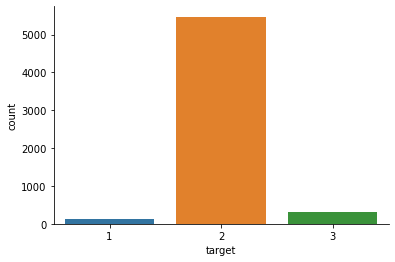

In [61]:
fig = plt.figure()
if not (REGRESSION and TARGET == 'target'):
    sns.countplot(data=test, x='target')
else:
    sns.histplot(data=test, x='target')
sns.despine()
fig.savefig(os.path.join(output_dir, 'prediction.png'))
logger.debug('Write figure to {}'.format(os.path.join(output_dir, 'prediction.png')))

In [62]:
logger.debug('Complete ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-17 23:05:42,802 - __main__ - DEBUG - Complete (16857.193 seconds passed)
